In [ ]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import imageio
import os
# from google.colab import files
from pyDOE import lhs
from scipy.fftpack import diff, fft, ifft
from scipy.integrate import odeint

import time

2024-11-29 19:19:41.111885: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 19:19:41.223775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 19:19:41.281840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 19:19:41.296334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 19:19:41.394267: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# Boundaries of the computational domain
xleft, xright = -np.pi, np.pi
t0, tfinal = 0, 1.0

# Gravitational constant
g = 1.0

In [ ]:
N_sensor_points = 100

### Subclassing layers

In [ ]:
# Define the normalization layer
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    return (inputs-self.xmin)/(self.xmax-self.xmin)

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

# Define the MLP layer
class MLP(tf.keras.layers.Layer):
  def __init__(self, n_layers, n_units, n_final, name=None):
    super(MLP, self).__init__(name=name)
    self.n_layers = n_layers
    self.n_units = n_units
    self.n_final = n_final
    self.layers = []
    for i in range(self.n_layers-1):
      self.layers.append(tf.keras.layers.Dense(self.n_units, activation='tanh'))
    self.layers.append(tf.keras.layers.Dense(self.n_final, activation='linear'))

  def call(self, inputs):
    h = inputs
    for i in range(self.n_layers):
      h = self.layers[i](h)
    return h

In [ ]:
# Characteristic scales
U_scale = 1.0
H_scale = 1.0
T = tfinal

delta = 0.0

# Initial conditions
z0 = lambda x: 0*x

# Analytical solution
a0 = lambda H: np.sqrt(g*H)
h_analytical = lambda t, x, x0, H: tf.where(x-x0<-a0(H)*t, a0(H)**2/g, tf.where(x-x0<2*a0(H)*t, (2*a0(H)-(x-x0)/t)**2/(9*g), 0.0))
u_analytical = lambda t, x, x0, H: tf.where(x-x0<-a0(H)*t, 0.0, tf.where(x-x0<2*a0(H)*t, 2/3*(a0(H)+(x-x0)/t), 0.0))

I0000 00:00:1732920583.768825 1944071 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-29 19:19:43.874587: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


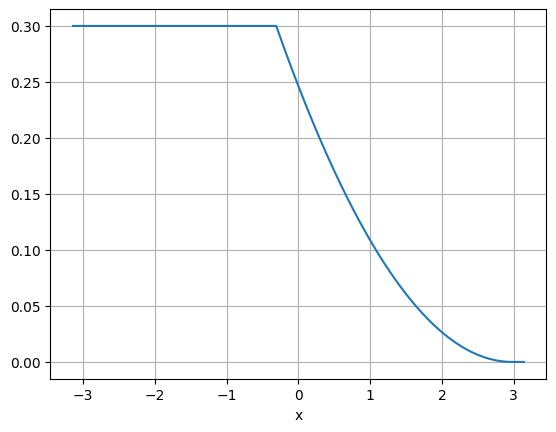

In [ ]:
x = np.linspace(xleft, xright, 1000).astype(np.float32)
plt.plot(x, h_analytical(2.0, x, x0=np.pi/4, H=0.3)+z0(x))
plt.xlabel('x')
plt.grid()

In [ ]:
def build_model(n_units=40, n_layers=8, summary=False):

  # Branch net
  inp_u = tf.keras.layers.Input(shape=(N_sensor_points,))
  bu = Normalize(0, U_scale)(inp_u)
  inp_h = tf.keras.layers.Input(shape=(N_sensor_points,))
  bh = Normalize(0, H_scale)(inp_h)

  # Trunk net
  inp_t = tf.keras.layers.Input(shape=(1,))
  b1 = Normalize(t0, tfinal)(inp_t)
  inp_x = tf.keras.layers.Input(shape=(1,))
  b2 = Normalize(xleft, xright)(inp_x)

  x = tf.keras.layers.Concatenate()([b1, b2, bu, bh])
  for i in range(n_layers):
    x = tf.keras.layers.Dense(n_units, activation='tanh')(x)

  h = tf.keras.layers.Dense(1, activation='linear')(x)
  u = tf.keras.layers.Dense(1, activation='linear')(x)

  model = tf.keras.models.Model([inp_t, inp_x, inp_u, inp_h], [u, h])

  if summary:
    model.summary()

  return model

In [ ]:
# def build_model(n_units=40, n_layers=4, p=80, summary=False):

#   # Branch net
#   inp_u = tf.keras.layers.Input(shape=(N_sensor_points,))
#   bu = Normalize(0, U_scale)(inp_u)
#   inp_h = tf.keras.layers.Input(shape=(N_sensor_points,))
#   bh = Normalize(0, H_scale)(inp_h)

#   branch_in = tf.keras.layers.Concatenate()([bu, bh])
#   branch = MLP(n_layers, n_units, p)(branch_in)

#   # Trunk net
#   inp_t = tf.keras.layers.Input(shape=(1,))
#   b1 = Normalize(t0, tfinal)(inp_t)

#   inp_x = tf.keras.layers.Input(shape=(1,))
#   b2 = Normalize(xleft, xright)(inp_x)

#   inp_tx = tf.keras.layers.Concatenate()([b1, b2])
#   trunk = MLP(n_layers, n_units, p)(inp_tx)

#   branch_h = tf.keras.layers.Lambda(lambda x: x[:,:p//2])(branch)
#   trunk_h = tf.keras.layers.Lambda(lambda x: x[:,:p//2])(trunk)

#   branch_u = tf.keras.layers.Lambda(lambda x: x[:,p//2:])(branch)
#   trunk_u = tf.keras.layers.Lambda(lambda x: x[:,p//2:])(trunk)

#   h = tf.keras.layers.Multiply()([branch_h, trunk_h])
#   h = tf.keras.layers.Dense(1, activation='linear')(h)

#   u = tf.keras.layers.Multiply()([branch_u, trunk_u])
#   u = tf.keras.layers.Dense(1, activation='linear')(u)

#   model = tf.keras.models.Model([inp_t, inp_x, inp_u, inp_h], [u, h])

#   if summary:
#     model.summary()

#   return model

In [ ]:
# def build_model(n_units=40, n_layers=6, summary=False):

#   # Branch net
#   inp_u = tf.keras.layers.Input(shape=(N_sensor_points,))
#   bu = Normalize(0, U_scale)(inp_u)
#   inp_h = tf.keras.layers.Input(shape=(N_sensor_points,))
#   bh = Normalize(0, H_scale)(inp_h)

#   # Trunk net
#   inp_t = tf.keras.layers.Input(shape=(1,))
#   b1 = Normalize(t0, tfinal)(inp_t)
#   inp_x = tf.keras.layers.Input(shape=(1,))
#   b2 = Normalize(xleft, xright)(inp_x)

#   # Nomad
#   x = tf.keras.layers.Concatenate()([bu, bh])
#   for i in range(n_layers):
#     x = tf.keras.layers.Dense(n_units, activation='tanh')(x)

#   x = tf.keras.layers.Concatenate()([b1, b2, x])
#   # x = tf.keras.layers.Concatenate()([b1, b2, bu, bh])
#   for i in range(n_layers):
#     x = tf.keras.layers.Dense(n_units, activation='tanh')(x)

#   h = tf.keras.layers.Dense(1, activation='linear')(x)
#   u = tf.keras.layers.Dense(1, activation='linear')(x)

#   u = tf.keras.layers.Lambda(lambda x: x*U_scale)(u)
#   h = tf.keras.layers.Lambda(lambda x: x*H_scale)(h)

#   model = tf.keras.models.Model([inp_t, inp_x, inp_u, inp_h], [u, h])

#   if summary:
#     model.summary()

#   return model

In [ ]:
model = build_model()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_31      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_28      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_61        │ (None, 1)         │          0 │ input_layer_30[0… │
│ (Normalize)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_63        │ (None, 1)         │          0 │ input_layer_31[0… │
│ (Normalize)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_57        │ (None, 100)       │          0 │ input_layer_28[0… │
│ (Normalize)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_59        │ (None, 100)       │          0 │ input_layer_29[0… │
│ (Normalize)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 202)       │          0 │ normalize_61[0][… │
│ (Concatenate)       │                   │            │ normalize_63[0][… │
│                     │                   │            │ normalize_57[0][… │
│                     │                   │            │ normalize_59[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 40)        │      8,120 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 40)        │      1,640 │ dense_70[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 40)        │      1,640 │ dense_71[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 40)        │      1,640 │ dense_72[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 40)        │      1,640 │ dense_73[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 40)        │      1,640 │ dense_74[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 40)        │      1,640 │ dense_75[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_77 (Dense)    │ (None, 40)        │      1,640 │ dense_76[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 1)         │         41 │ dense_77[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 1)         │         41 │ dense_77[0][0]    │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 19,682 (76.88 KB)

 Trainable params: 19,682 (76.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def defineCollocationPoints(t_bdry, x_bdry, N=1000):

  # Convert input to numpy array
  t_bdry, x_bdry = np.array(t_bdry), np.array(x_bdry)

  # Uniform random sampling for PDE points
  tx_min = np.array([t_bdry[0], x_bdry[0]])
  tx_max = np.array([t_bdry[1], x_bdry[1]])
  pde_points = tx_min + (tx_max - tx_min)*lhs(2, N)
  t_pde = pde_points[:, 0]
  x_pde = pde_points[:, 1]

  # Stack all the PDE point data together
  pdes = np.column_stack([t_pde, x_pde]).astype(np.float32)

  # Where to evaluate the sensor points
  xpoints = np.linspace(xleft, xright, N_sensor_points).astype(np.float32)

  # Sample a new IC
  H = np.random.uniform(0.1, 1, (N,1))
  x0 = np.random.uniform(-np.pi/4, np.pi/4, (N,1))
  t0 = np.random.uniform(0, 2, (N,1))

   # Initial conditions
  ic_points = tx_min[1:] + (tx_max[1:] - tx_min[1:])*lhs(1, N)
  x_ic = ic_points[:, 0]
  u_ic = u_analytical(t0, x_ic.reshape((-1,1)), x0, H)
  h_ic = h_analytical(t0, x_ic.reshape((-1,1)), x0, H)
  ics = np.column_stack([0*t0, x_ic, u_ic, h_ic]).astype(np.float32)

  # Boundary conditions
  bc_points = tx_min[:1] + (tx_max[:1] - tx_min[:1])*lhs(1, N)
  t_bc = bc_points[:, 0]

  xl = x_bdry[0] + 0*t_bc[:N//2]
  xr = x_bdry[1] + 0*t_bc[N//2:]
  tl = t0[:N//2,0] + t_bc[:N//2]
  tr = t0[N//2:,0] + t_bc[N//2:]

  x_bc = np.concatenate(([xl, xr])).flatten()
  u_bc = np.concatenate(([u_analytical(tl.reshape((-1,1)), xl.reshape((-1,1)), x0[:N//2], H[:N//2])], [u_analytical(tr.reshape((-1,1)), xr.reshape((-1,1)), x0[N//2:], H[N//2:])])).flatten()
  h_bc = np.concatenate(([h_analytical(tl.reshape((-1,1)), xl.reshape((-1,1)), x0[:N//2], H[:N//2])], [h_analytical(tr.reshape((-1,1)), xr.reshape((-1,1)), x0[N//2:], H[N//2:])])).flatten()

  bcs = np.column_stack([t_bc, x_bc, u_bc, h_bc]).astype(np.float32)

  # Sensor points
  us = u_analytical(t0, xpoints, x0, H)
  hs = h_analytical(t0, xpoints, x0, H)
  sensors = np.concatenate([us, hs], axis=1).astype(np.float32)

  return pdes, ics, bcs, sensors

In [ ]:
N = 10000
pdes, ics, bcs, sensors = defineCollocationPoints([t0, tfinal], [xleft, xright], N)

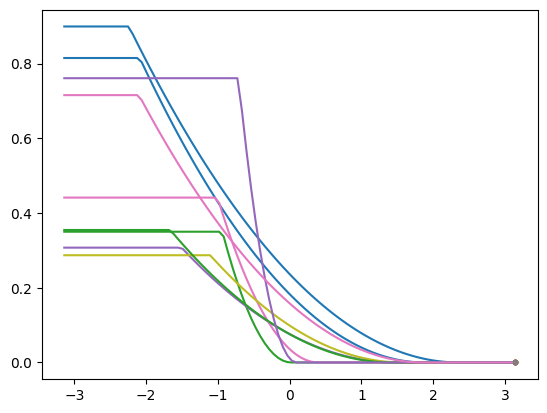

In [ ]:
# plt.plot(sensors[:,:N_sensor_points])
for pt in range(-1,-10,-1):
  xpoints = np.linspace(xleft, xright, N_sensor_points).astype(np.float32)
  plt.plot(xpoints, sensors[pt,N_sensor_points:])
  plt.plot(bcs[pt,1], bcs[pt,3],'.')

In [ ]:
@tf.function
def trainStep(pdes, ics, bcs, sensors, model):

  t, x = pdes[:,:1], pdes[:,1:2]
  ti, xi, ui, hi = ics[:,:1], ics[:,1:2], ics[:,2:3], ics[:,3:4]
  tb, xb, ub, hb = bcs[:,:1], bcs[:,1:2], bcs[:,2:3], bcs[:,3:4]
  usensor, hsensor = sensors[:,:N_sensor_points], sensors[:,N_sensor_points:]

  # Outer gradient for tuning network parameters
  with tf.GradientTape() as tape:

    with tf.GradientTape(persistent=True) as tape1:
      tape1.watch(t), tape1.watch(x)
      [u, h] = model([t, x, usensor, hsensor])
      z = z0(x)
      hu = h*u
      flux = h*u**2 + 0.5*g*h**2

    # Required derivatives
    ht = tape1.gradient(h, t)
    fluxx = tape1.gradient(flux, x)
    zx = tape1.gradient(z, x)
    [hut, hux] = tape1.gradient(hu, [t, x])

    # Solve the shallow-water equations
    eqn1 = ht + hux
    eqn2 = hut + fluxx + g*h*zx

    # Define the PDE loss
    Eqn1 = 10*tf.reduce_mean(eqn1**2)*(T/H_scale)**2
    Eqn2 = 10*tf.reduce_mean(eqn2**2)*(T/H_scale/U_scale)**2
    PDEloss = Eqn1 + Eqn2

    # Initial value loss
    [ui_pred, hi_pred] = model([ti, xi, usensor, hsensor])
    IC1 = 10*tf.reduce_mean((hi-hi_pred)**2)/H_scale**2
    IC2 = 10*tf.reduce_mean((ui*hi-ui_pred*hi_pred)**2)/(U_scale*H_scale)**2
    ICloss = IC1 + IC2

    # Boundary loss
    [ub_pred, hb_pred] = model([tb, xb, usensor, hsensor])
    BC1 = 10*tf.reduce_mean((hb-hb_pred)**2/H_scale**2)
    BC2 = 10*tf.reduce_mean((ub*hb-ub_pred*hb_pred)**2/(H_scale*U_scale)**2)
    BCloss = BC1 + BC2

    # Total loss
    loss = PDEloss + ICloss + BCloss

  # Compute the gradient of the global loss wrt the model parameters
  grads = tape.gradient(loss, model.trainable_variables)

  return PDEloss, ICloss, BCloss, grads, Eqn1, Eqn2, IC1, IC2, BC1, BC2

In [ ]:
def train(pde_points, ic_points, bc_points, sensors, epochs=1000):

  # Optimizer for the problem
  lr = tf.keras.optimizers.schedules.PolynomialDecay(1e-3, decay_steps=epochs,
                                                     end_learning_rate=1e-3)
  opt = tf.keras.optimizers.Adam(lr)

  # Number of collocation points
  nr_points = len(pde_points)

  # Batch sizes
  batch_factor = 10 #10
  batch_size = nr_points//(batch_factor)

  ds_uh = tf.data.Dataset.from_tensor_slices(sensors)
  ds_ic = tf.data.Dataset.from_tensor_slices(ic_points)
  ds_bc = tf.data.Dataset.from_tensor_slices(bc_points)
  ds_pde = tf.data.Dataset.from_tensor_slices(pde_points)

  ds = tf.data.Dataset.zip((ds_pde, ds_ic, ds_bc, ds_uh))
  ds = ds.cache().shuffle(N).batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

  # Optimizer and learning rate to be used
  lr = 1e-3
  opt = tf.keras.optimizers.Adam(lr)

  epoch_loss = np.zeros(epochs)
  pde_loss = np.zeros(epochs)
  ic_loss = np.zeros(epochs)
  bc_loss = np.zeros(epochs)

  # Main training loop
  for i in range(epochs):

    nr_batches = 0

    # Train the model
    for (pdes, ics, bcs, sensors) in ds:

      # Train the network
      pdeloss, icloss, bcloss, grads, e1, e2, i1, i2, b1, b2 = trainStep(pdes, ics, bcs, sensors, model)

      # Gradient step
      opt.apply_gradients(zip(grads, model.trainable_variables))

      epoch_loss[i] += pdeloss + icloss
      pde_loss[i] += pdeloss
      ic_loss[i] += icloss
      bc_loss[i] += bcloss
      nr_batches += 1

    # Get total epoch loss
    epoch_loss[i] /= nr_batches
    pde_loss[i] /= nr_batches
    ic_loss[i] /= nr_batches
    bc_loss[i] /= nr_batches

    if (np.mod(i, 100)==0):
      print(f"Epochs {i}: EH loss: {e1: 2.4f}, EHU loss: {e2: 2.4f}, IH loss: {i1: 2.4f}, IHU loss: {i2: 2.4f}, BH loss: {b1: 2.4f}, BHU loss: {b2: 2.4f}")
      # print(f"Epochs {i}: PDE loss: {pde_loss[i]: 2.4f}, IC loss: {ic_loss[i]: 2.4f}, BC loss: {bc_loss[i]: 2.4f}")

  return epoch_loss, pde_loss, ic_loss, bc_loss

In [ ]:
epochs = 20000
loss, pde_loss, ic_loss, bc_loss = train(pdes, ics, bcs, sensors, epochs)

Epochs 0: EH loss:  0.0019, EHU loss:  0.0016, IH loss:  0.8631, IHU loss:  0.0395, BH loss:  1.0391, BHU loss:  0.0419
Epochs 100: EH loss:  0.0017, EHU loss:  0.0011, IH loss:  0.0082, IHU loss:  0.0027, BH loss:  0.0014, BHU loss:  0.0004
Epochs 200: EH loss:  0.0009, EHU loss:  0.0007, IH loss:  0.0039, IHU loss:  0.0014, BH loss:  0.0012, BHU loss:  0.0003
Epochs 300: EH loss:  0.0006, EHU loss:  0.0004, IH loss:  0.0026, IHU loss:  0.0008, BH loss:  0.0005, BHU loss:  0.0001
Epochs 400: EH loss:  0.0004, EHU loss:  0.0005, IH loss:  0.0052, IHU loss:  0.0022, BH loss:  0.0012, BHU loss:  0.0006
Epochs 500: EH loss:  0.0003, EHU loss:  0.0002, IH loss:  0.0017, IHU loss:  0.0006, BH loss:  0.0002, BHU loss:  0.0001
Epochs 600: EH loss:  0.0003, EHU loss:  0.0002, IH loss:  0.0018, IHU loss:  0.0005, BH loss:  0.0003, BHU loss:  0.0001
Epochs 700: EH loss:  0.0002, EHU loss:  0.0002, IH loss:  0.0008, IHU loss:  0.0003, BH loss:  0.0004, BHU loss:  0.0001
Epochs 800: EH loss:  0.00

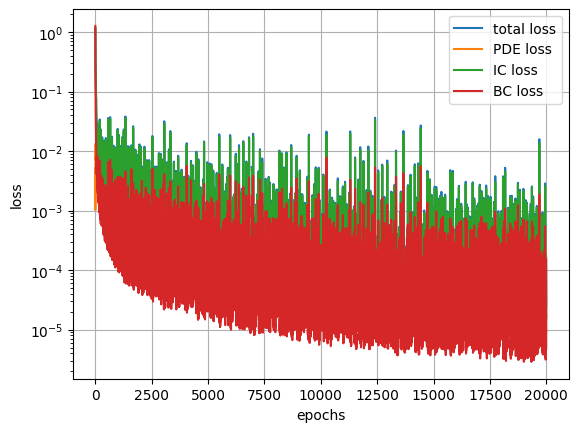

In [ ]:
plt.semilogy(range(0, epochs), loss)
plt.semilogy(range(0, epochs), pde_loss)
plt.semilogy(range(0, epochs), ic_loss)
plt.semilogy(range(0, epochs), bc_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['total loss', 'PDE loss', 'IC loss', 'BC loss'])
plt.grid()

In [ ]:
# Grid where to evaluate the model
l, m = 10, 2*N_sensor_points
t0 = 0.0
t = np.linspace(t0, tfinal, l)
x = np.linspace(xleft, xright, m)
TT, XX = np.meshgrid(t, x, indexing='ij')

In [ ]:
# Sample a new IC
x_points = np.linspace(xleft, xright, N_sensor_points).astype(np.float32)

H = np.random.uniform(0.1, 1.0)
x0 = np.random.uniform(-np.pi/4, np.pi/4)
t0 = np.random.uniform(0, 1.0)

# Case 1
# H = 0.75
# x0 = 0.25
# t0 = 0.25

# Case 2
H = 0.25
x0 = -0.25
t0 = 0.75

# Case 3
# H = 0.5
# x0 = 0.0
# t0 = 0.01

u_init = u_analytical(t0, x_points, x0, H)
h_init = h_analytical(t0, x_points, x0, H)

In [ ]:
print(f't={t0:1.2f}, x0={x0:1.2f}, H={H:1.2f}.')

t=0.75, x0=-0.25, H=0.25.


In [ ]:
dt = t[1]-t[0]

In [ ]:
tt = TT.flatten().reshape(-1,1)
xx = XX.flatten().reshape(-1,1)
uu = np.repeat(np.expand_dims(u_init, axis=0), len(tt), axis=0)
hh = np.repeat(np.expand_dims(h_init, axis=0), len(tt), axis=0)

[u, h] = model([tt, xx, uu, hh])
u = np.reshape(u, (l, m))
h = np.reshape(h, (l, m))

In [ ]:
hTrue = h_analytical(TT+t0, XX, x0, H)
uTrue = u_analytical(TT+t0, XX, x0, H)

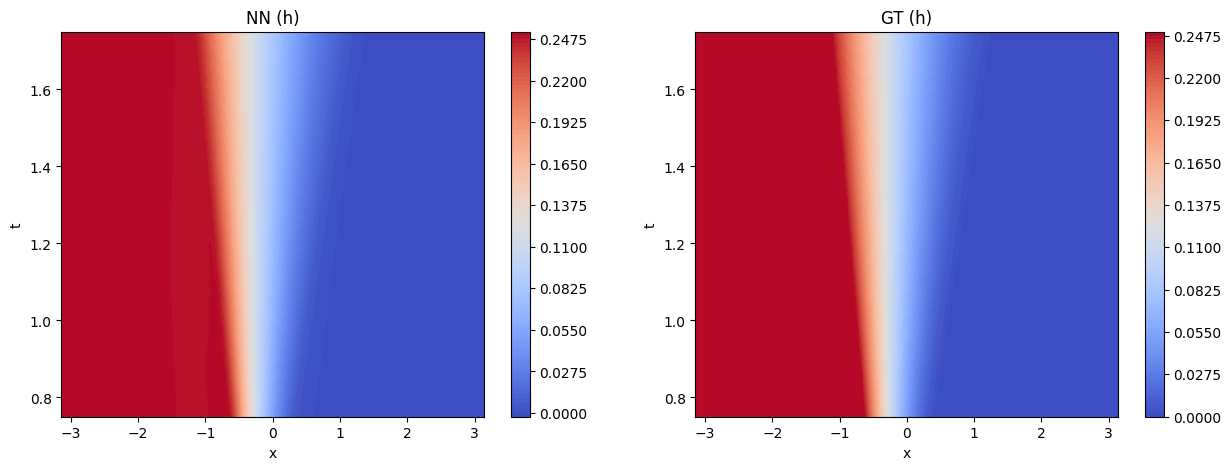

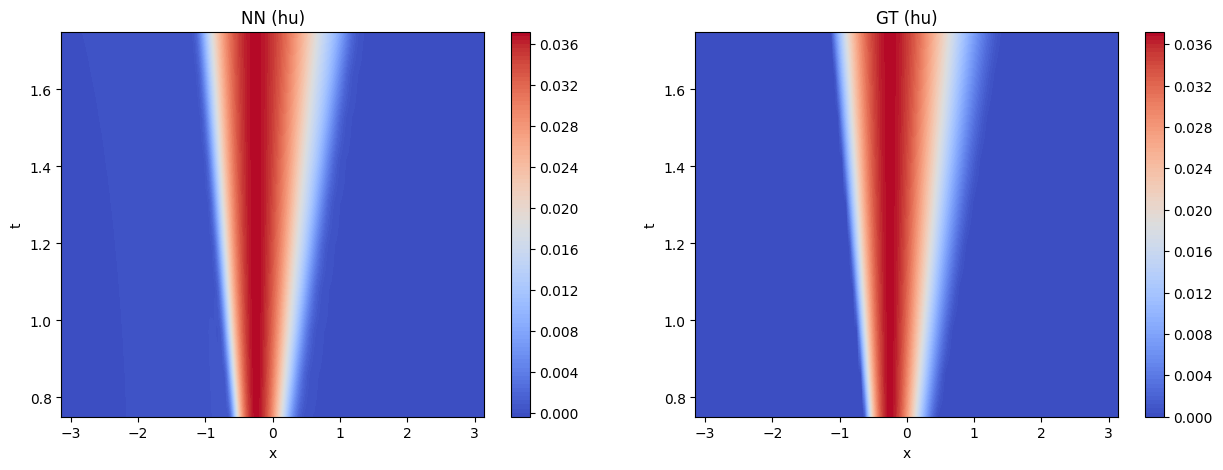

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.contourf(XX, TT+t0, h, 100, cmap=plt.cm.coolwarm)
plt.title('NN (h)')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(122)
plt.contourf(XX, TT+t0, hTrue, 100, cmap=plt.cm.coolwarm)
plt.title('GT (h)')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.contourf(XX, TT+t0, h*u, 100, cmap=plt.cm.coolwarm)
plt.title('NN (hu)')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(122)
plt.contourf(XX, TT+t0, hTrue*uTrue, 100, cmap=plt.cm.coolwarm)
plt.title('GT (hu)')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

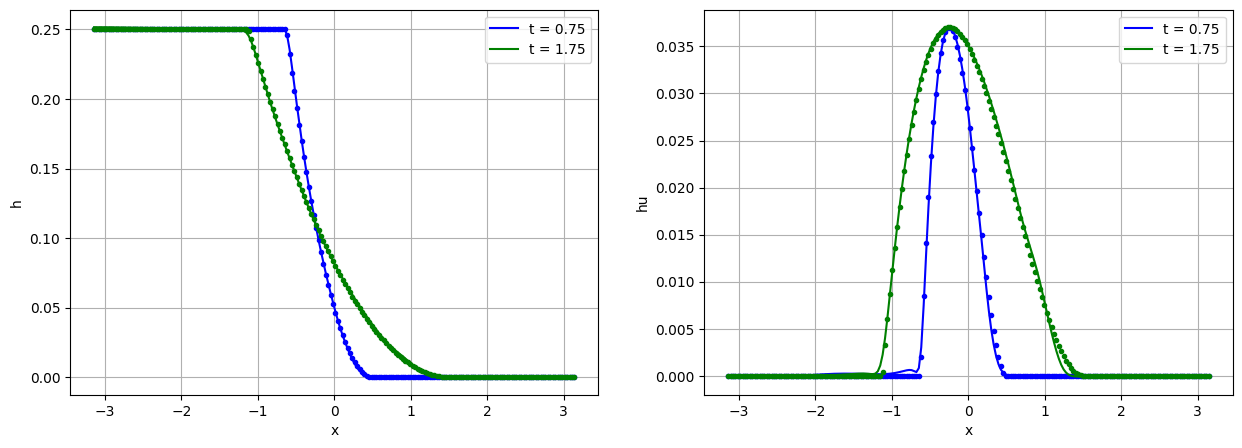

In [ ]:
fig = plt.figure(figsize=(15,5))

steps = [0, -1]
colors = ['b', 'g', 'k']

plt.subplot(121)
for p, c in zip(steps,colors):
  plt.plot(x, h[p,], color=c, label=f't = {t[p]+t0:1.2f}')
  plt.plot(x, hTrue[p,], '.', color=c)#, label=f'GT t = {p}')
plt.legend()
# plt.axis([-300, 300, -0.05, 10.05])
plt.xlabel('x')
plt.ylabel('h')
plt.grid()

plt.subplot(122)
for p, c in zip(steps,colors):
  plt.plot(x, h[p,]*u[p,], color=c, label=f't = {t[p]+t0:1.2f}')
  plt.plot(x, hTrue[p,]*uTrue[p,], '.', color=c)#, label=f'GT t = {p}')
plt.legend()
# plt.axis([-300, 300, -0.05, 10.05])
plt.xlabel('x')
plt.ylabel('hu')
plt.grid()

plt.savefig(f'DamBreak_hu_t0_{t0:1.3f}_x0_{x0:1.3f}_H_{H:1.3f}.png')

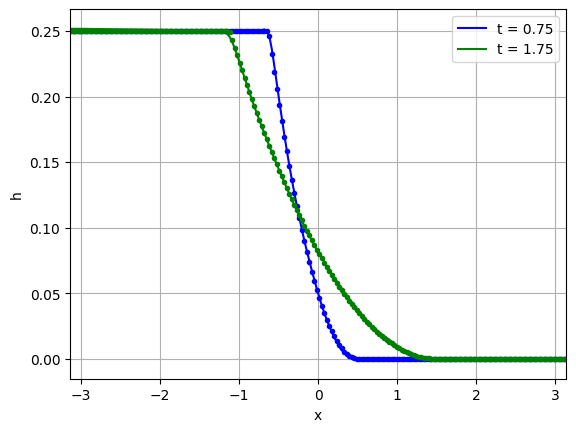

In [ ]:
for p, c in zip(steps,colors):
  plt.plot(x, h[p,], color=c, label=f't = {t[p]+t0:1.2f}')
  plt.plot(x, hTrue[p,], '.', color=c)#, label=f'GT t = {p}')
plt.legend()
# plt.axis([-300, 300, -0.05, 10.05])
plt.xlabel('x')
plt.ylabel('h')
plt.grid()
plt.axis([xleft, xright, h.min()-0.015, h.max()+0.015])
plt.savefig(f'DamBreak_t0_{t0:1.3f}_x0_{x0:1.3f}_H_{H:1.3f}.png')

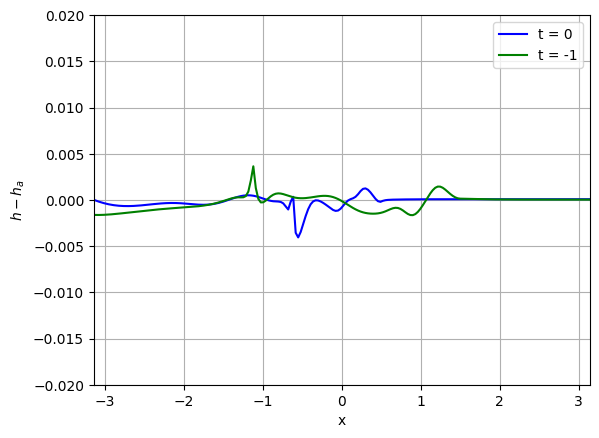

In [ ]:
for p, c in zip(steps,colors):
  plt.plot(x, hTrue[p,]-h[p,], color=c, label=f't = {p}')
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$h-h_a$')
plt.grid()
# plt.axis([-300, 300, -0.20, 0.20])
plt.axis([xleft, xright, -0.02, 0.02])
plt.savefig(f'DamBreakError_t0_{t0:1.3f}_x0_{x0:1.3f}_H_{H:1.3f}.png')

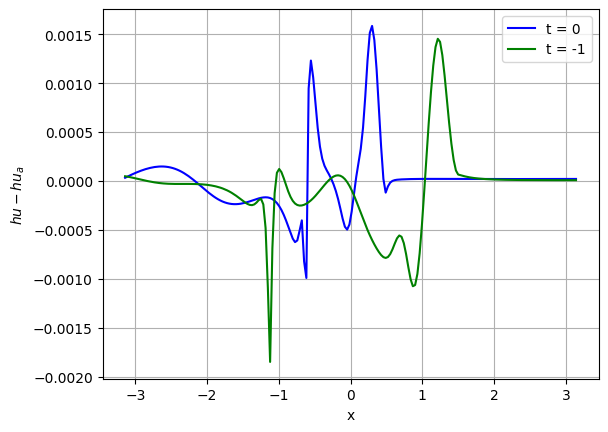

In [ ]:
for p, c in zip(steps,colors):
  plt.plot(x, uTrue[p,]*hTrue[p,]-u[p,]*h[p,], color=c, label=f't = {p}')
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$hu-hu_a$')
plt.grid()
# plt.axis([-300, 300, -0.20, 0.20])
plt.savefig(f'DamBreakHUError_t0_{t0:1.3f}_x0_{x0:1.3f}_H_{H:1.3f}.png')

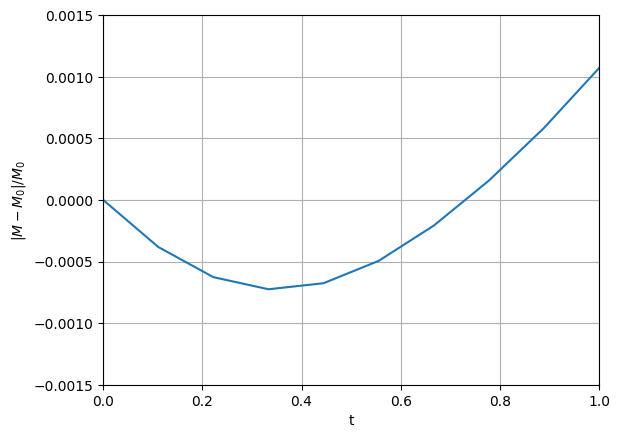

In [ ]:
mass = np.sum(h, axis=1)

plt.plot(t, (mass-mass[0])/mass[0])
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$|M-M_0|/M_0$')
plt.axis([0.0, tfinal, -0.0015, 0.0015])
plt.savefig(f'DamBreakMassError_t0_{t0:1.3f}_x0_{x0:1.3f}_H_{H:1.3f}.png')